<a href="https://colab.research.google.com/github/diptivs/machine_learning/blob/master/enron_ML_email_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Configuration of the System : Iterative, Notebook, code structure, data, where will it reside, folders, cloud buckets etc.

###Import all required libraries

In [0]:
from numpy import vstack,array
from numpy.random import rand
import numpy as np

import pandas as pd
import pandas_datareader as dr

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

import tensorflow as tf

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
import wordcloud

# Network analysis
import networkx as nx

from pylab import plot,show
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.cm as cm


from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch



from math import sqrt
from datetime import datetime
import time as time
import os, sys, email




#2. Data Collection : initial Data Set

## Datasets used:

* Enron email Database: https://drive.google.com/open?id=1pusOXGv08y87WtuPwJaHmBJHLtsS-n_M : [Ref: https://www.cs.cmu.edu/~enron/ and https://www.kaggle.com/wcukierski/enron-email-dataset]
* Enron stock data: https://drive.google.com/open?id=1N67jVHSuSNxEr4sjSUn6FLkHJIjDWBZv [Ref: http://law2.umkc.edu/faculty/projects/ftrials/enron/enronstockchart.pdf]
* Filtered enron dataset considering only business related emails : https://drive.google.com/open?id=11lPvgEFcgunoLjq_N2qAB_26-Hs4_z29 [Ref: http://bailando.sims.berkeley.edu/enron_email.html https://data.world/brianray/enron-email-dataset]
* Enron Quaterly results: https://drive.google.com/open?id=18JdemaFLryIq5pypvM1wJ4C2hdz9CDhn [Ref: http://picker.uchicago.edu/Enron/EnronAnnualReport1999.pdf, http://i.cnn.net/cnn/2002/LAW/02/02/enron.report/powers.report.pdf]
* Enron insider financial data : https://drive.google.com/open?id=1E-ETQM1kY-8n2Rr0AVXqJvvusHqij2Pq [Ref: https://benefitslink.com/articles/enronJCT2003.pdf, https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf]
* Filtered data based on important timelines: https://docs.google.com/document/d/1dUbg1D2-tTPuSH-RwtzWRedTgqjFOTn0syF_qTciVS0/edit?usp=sharing Ref: https://drive.google.com/file/d/1HLdvEajR_WAOkXtYP0TuBpZzaN87uXt2/view 
* Filtered further considering people of interest: https://drive.google.com/file/d/18KETpfmcTNWCxAEDN4reGEzJmCkOcGnJ/view

###Load Data from Google drive

####Setup Google Auth

In [0]:
# Setup google auth
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

####Load email Dataset

Email dataset:
* emails.csv: https://drive.google.com/open?id=1pusOXGv08y87WtuPwJaHmBJHLtsS-n_M

In [0]:
file_id = '1pusOXGv08y87WtuPwJaHmBJHLtsS-n_M'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('emails.csv') 

####Download dataset generated using email database, running Vader on it for generating features indicating email sentiments and stock data
The dataSet contains total of 25 columns generated by merging emails dataset and stocks data for enron. After running Vader on email Dataset, the coloumns indicating emotions were generated which are positive, negative, neutral, compound and emotions. 

* emails_parsed_sentiment_n_stock_nlp.csv: https://drive.google.com/open?id=1riBaT9mQD_yx-1zoKILkiRXZOEkeCxES


In [0]:
file_id = '1riBaT9mQD_yx-1zoKILkiRXZOEkeCxES'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('emails_parsed_sentiment_n_stock.csv')  

####Download dataset generated using Labels from Kmean. 

Added one feture to dataset named LABEL which contains Labels from Kmean clustering on base dataset
* emails_parsed_sentiment_n_stock_nlp_Kmean_Labels.csv: https://drive.google.com/open?id=1-7NtDS3z9iiaGONsHfU8vX1EtuKNM07O

In [0]:
file_id = '1-7NtDS3z9iiaGONsHfU8vX1EtuKNM07O'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('emails_parsed_sentiment_n_stock_nlp.csv')  

####Download dataset generated after filtering the original dataset based on POI + Important_dates

The base data is filtered using:
* Important Dates + quaterly result dates using information available here:
 * Enron Quaterly results: https://drive.google.com/open?id=18JdemaFLryIq5pypvM1wJ4C2hdz9CDhn [Ref: http://picker.uchicago.edu/Enron/EnronAnnualReport1999.pdf, http://i.cnn.net/cnn/2002/LAW/02/02/enron.report/powers.report.pdf]
  * Filtered data based on important timelines: https://docs.google.com/document/d/1dUbg1D2-tTPuSH-RwtzWRedTgqjFOTn0syF_qTciVS0/edit?usp=sharing Ref: https://drive.google.com/file/d/1HLdvEajR_WAOkXtYP0TuBpZzaN87uXt2/view
* This dataset was further filtered based on list of poepl of interests here:
  * Enron insider financial data : https://drive.google.com/open?id=1E-ETQM1kY-8n2Rr0AVXqJvvusHqij2Pq [Ref: https://benefitslink.com/articles/enronJCT2003.pdf, https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf]
  *  people of interest: https://drive.google.com/file/d/18KETpfmcTNWCxAEDN4reGEzJmCkOcGnJ/view

Below is the filtered dataset:
* poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv :https://drive.google.com/open?id=1-0pq225BgdBDnBkmj8jK5OPPzMf9QRtz

In [0]:
file_id = '1-0pq225BgdBDnBkmj8jK5OPPzMf9QRtz'
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv') 

#3. Set Data Narrative : Set Business Objectives, what use case are you solving 

Learning enron dataset to find the relation between emotions and stock value.

#4. Exploratory Data Analysis and Visualization

##4.1 Feature analysis and engineering (for ML, for DL it's feature extraction)

###Load Data

In [0]:
#Load data
data_in = pd.read_csv('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv').replace(np.nan, 0)
data_in.head()

data_in.drop(data_in.query(
    "ChangePercent == '0' | EmailTs == '0' | positive == '0' | negative == '0' | neutral =='0' | compound == '0'"
).index, inplace=True)

###Feature selection using SelectKBest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


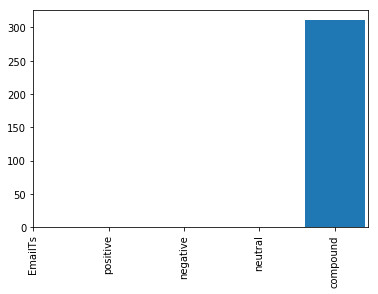

In [0]:
predictors = ["EmailTs", "positive", "negative", "neutral","compound"]


# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(data_in[predictors], data_in["ChangePercent"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

##4.2 Analyze data 

###Load Data

In [0]:
emails_df = pd.read_csv('emails.csv')

###4.2.1 Exploratory analyses of email dataset

####Helper function

In [0]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

####Single message looks like this:

In [0]:
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


####Parse the emails into a list email objects

In [0]:
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


####Find number of unique values in each columns

In [0]:
print('shape of the dataframe:', emails_df.shape)

for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


#####Set index and drop columns with too few values

In [0]:
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'],utc=True, infer_datetime_format=True)

emails_df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

####When do people send emails?

Text(0, 0.5, 'N emails')

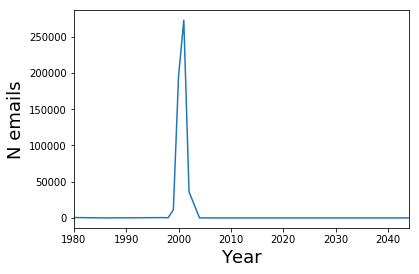

In [0]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

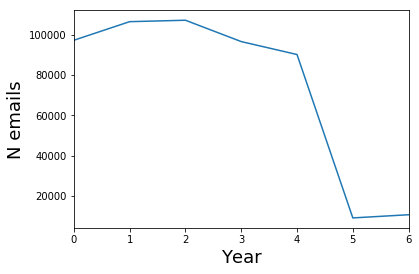

In [0]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

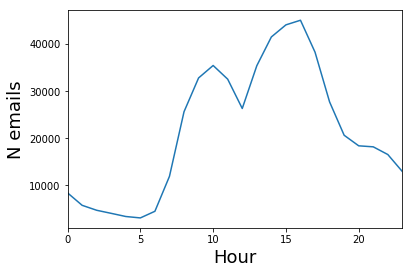

In [0]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

####Who sends most emails?

In [0]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [0]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,28465,4.217530,255.906025
dasovich-j,28234,5.237373,603.393391
kean-s,25351,4.959331,490.837561
mann-k,23381,4.211796,207.195501
jones-t,19950,4.748221,185.462607


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


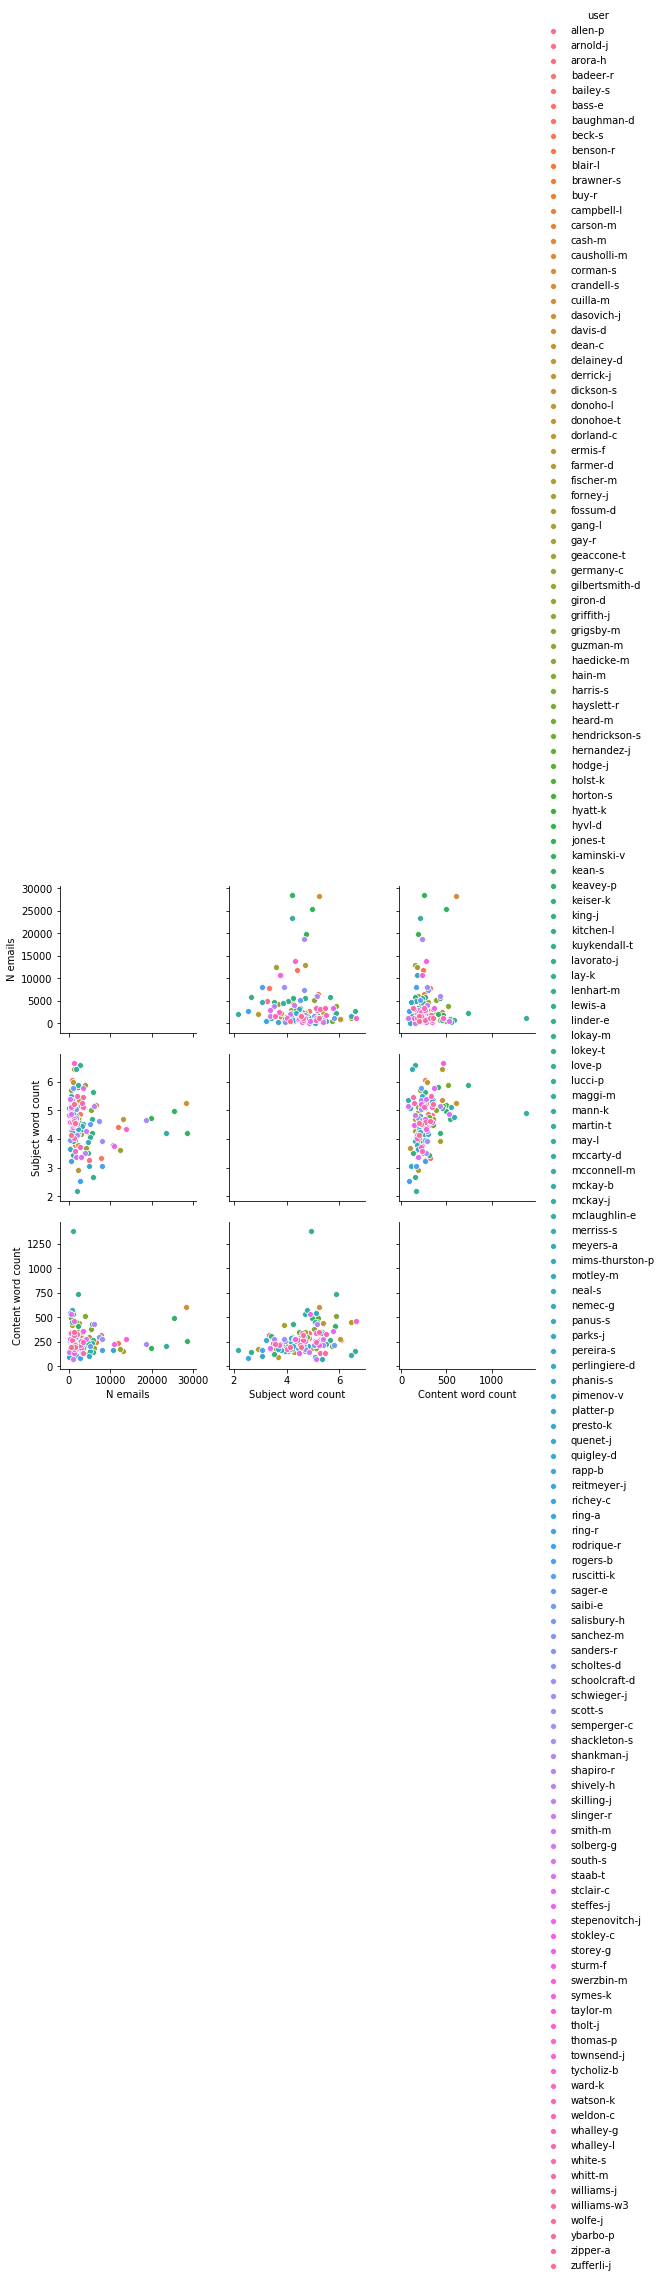

In [0]:
sns.pairplot(grouped_by_people.reset_index(), hue='user')

###4.2.2 Social network analyses of email senders and recipients

####Let's see who sends the most emails to whom

First we'll only look at emails sent to single email address, which may be more important personal communications

In [0]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


In [0]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


Apparently some people send a lot of emails to themselves. It maybe very interesting to look at the differences between emails sent to selves and to others.

In [0]:
# Make a network of email sender and receipients
G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 25396, Number of edges: 56144


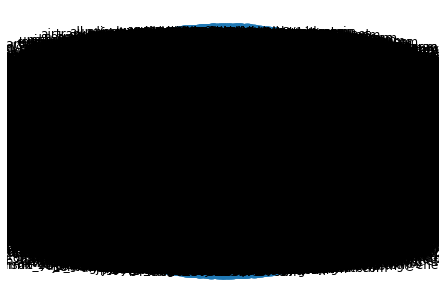

In [0]:
nx.draw(G,with_labels=True)
plt.show()

####Examine connected components in the network

(0.1, 10000.0)

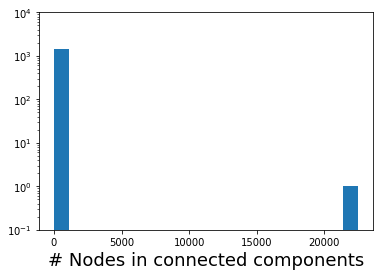

In [0]:
n_nodes_in_cc = []
for nodes in nx.connected_components(G.to_undirected()):
    n_nodes_in_cc.append(len(nodes))

plt.hist(n_nodes_in_cc, bins=20, log=True)
plt.xlabel('# Nodes in connected components', fontsize=18)
plt.ylim([.1,1e4])

####What do the emails say?

#####In Subjects

(-0.5, 799.5, 599.5, -0.5)

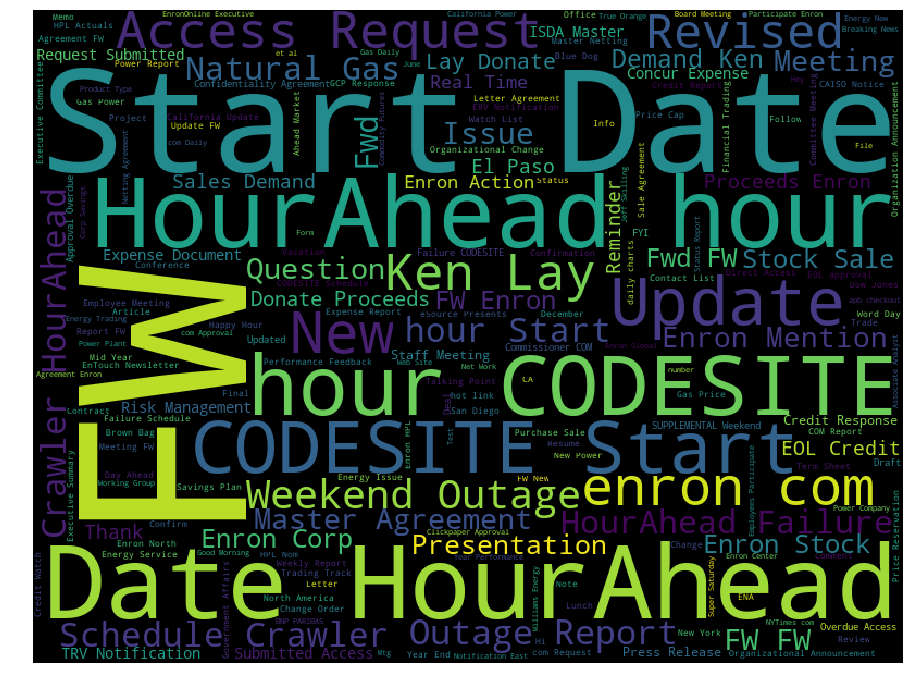

In [0]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

#####In Contents

(-0.5, 799.5, 599.5, -0.5)

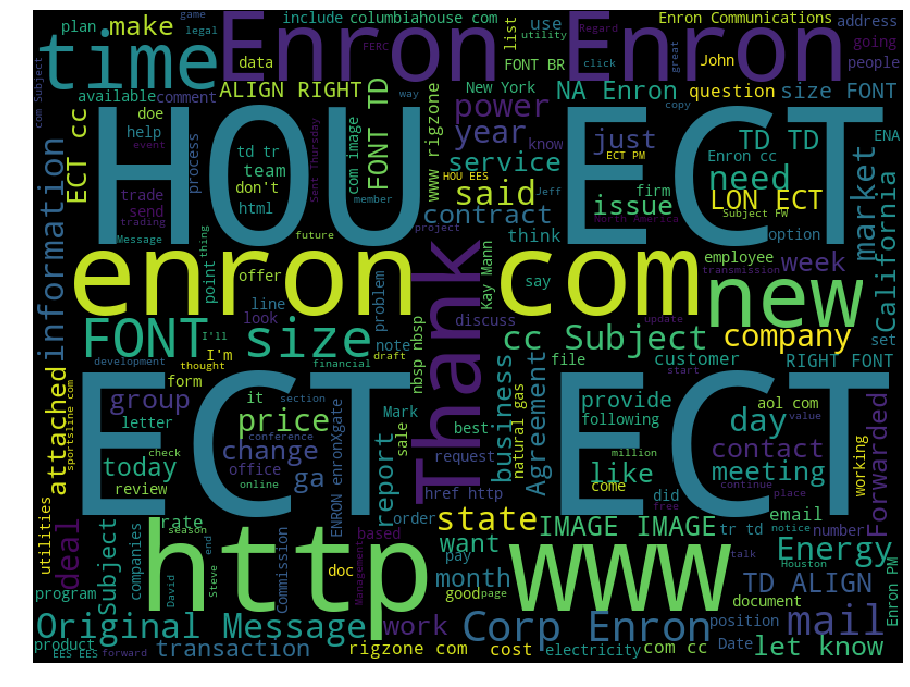

In [0]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")

##4.3 Visualize data

Load dataset

In [0]:
data_in = pd.read_csv('emails_parsed_sentiment_n_stock_nlp.csv')
df_filtered = data_in[data_in['change'] != 0] 
dataset = df_filtered

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyError: ignored

###Plot Change Percent vs Emotions Compound values

In [0]:
data_in.plot(x='compound', y='change_percent', style='o')  
plt.title('Compound vs ChangePercent {}'.format(fname))
plt.xlabel('compound')  
plt.ylabel('change_percent')  
plt.show()

###Visualizing the average ChangePercent value

In [0]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataset['change_percent'])

##4.4 Run Stats: mean, median, mode, correlation, variance

##4.5 corr

In [0]:
#Load data
data_in = pd.read_csv('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv', index_col="id")

In [0]:
X = data_in.iloc[:,0:23]  #independent columns
y = data_in.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = data_in.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(23,23))
#plot heat map
g=sns.heatmap(data_in[top_corr_features].corr(),annot=True,cmap="RdYlGn")

##4.6 pairplot()

In [0]:
#Load data
data_in = pd.read_csv('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv', index_col="id")

##4.7 gini score

In [0]:
#Descision tree

##4.8 feature_importance with xgboost

#5. Data Prep: Curation

##5.1 Feature Selection and Extraction : what are the main features to use in this data set?

In [0]:
#describe features used differntly

##5.2 Data Verification: Do we have enough data?

In [0]:
#discuss different dataset used

##5.3 Possibility of Amalgamation1: Add Dataset 2

In [0]:
#discuss all amalgamations performed

##5.4 Data Cleansing

In [0]:
#all cleaning strategies

##5.5 Data Regularization

##5.6 Data Normalization

#6. Unsupervised Exploration : Find relevant Clusters in Your Data

##6.1 How many clusters? Explore different k’s…

###Elbow curve:  On Base dataset

In [0]:
data_in = pd.read_csv('emails_parsed_sentiment_n_stock_nlp.csv', index_col="id")
data = np.asarray([np.asarray(data_in['ChangePercent']), np.asarray(data_in['compound'])]).T
X = data

distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

##6.2 Select Clustering algorithms, run several and compare in a table

* Used features "ChangePercent" of stock value and "compound" value of emotions
* Ran Kmean clustering on this dataset
* Generated new feature named "Label" based on clusers labels



The dataSet contains total of 25 columns generated by merging emails dataset and stocks data for enron. After running Vader on email Dataset, the coloumns indicating emotions were generated which are positive, negative, neutral, compound and emotions. The coloumns used for clustering are precentage change of stock price and compound value of emotions.

Currently id is used as index but have also tried with Date as index. Clustering looks similar.

The stock change data is spread across the emotions. So with current clustering results we really could not visualize the relationship between stock change and emotions. We will be labelling this data as per clustering results and process further.

###6.2.1 On base dataset

This is an attempt to perform clustering on ENRON dataset. The data set is a merge between ENRON emails and stock prices. Prior to merge, sentiment analysis was conducted on the email messages and new columns added to the database. The merge was done on the Date field.

The clustering will be done on two fields within dataset: the ChangePercent of the stock prices for the day and the compound score for the sentiment.

In [0]:
data_in = pd.read_csv('emails_parsed_sentiment_n_stock_nlp.csv', index_col="id")
data_in.index = pd.to_datetime(data_in.index)
data = np.asarray([np.asarray(data_in['ChangePercent']), np.asarray(data_in['compound'])], dtype=np.float32).T
X = data

data_reduced = pd.read_csv('emails_parsed_sentiment_n_stock_nlp.csv', index_col="id",nrows=10000)
data_reduced = np.asarray([np.asarray(data_reduced['ChangePercent']), np.asarray(data_reduced['compound'])]).T

Y = data_reduced

####K-mean

#####Sklearn

In [0]:
#kmean
kmeans = KMeans(n_clusters = 3).fit(X)
centroids = kmeans.cluster_centers_
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.title("K-means clustering with SKLearn framework")
plt.show()

#####TensorFlow

In [0]:
k = 3
n = 100
variables = 2
points = X
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=False)
previous_centers = None
for _ in range(10):
    kmeans.train(input_fn)
    centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', centers - previous_centers)
    previous_centers = centers
    #print('score:', kmeans.score(input_fn))
#print('centers:', centers)
cluster_indices = list(kmeans.predict_cluster_index(input_fn))


#plt.scatter(X[:,0],X[:,1], c = model_fn.labels_, cmap ="rainbow")
#plt.show()

plt.scatter(points[:, 0], points[:, 1], c=cluster_indices, s=50, alpha=0.5, cmap ="rainbow")
plt.plot(centers[:, 0], centers[:, 1], 'kx', markersize=15)
plt.title("K-means clustering with Tensorflow framework")
plt.show()

#####K-mean Plot Stretch

In [0]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=3, random_state=0)
plot_kmeans(kmeans, X_stretched)

####GMM

#####Using tensor flow

From the chart we can see the relationship betweeen emails and stock prices. Not all negative emails affected the price negatively. However we can see which emails were being sent when stock performed well, poor and neutral.

In [0]:

DIMENSIONS = 2
CLUSTERS = 3
DATA_POINTS = len(data_in)
TRAINING_STEPS = 1000
TOLERANCE = 0

def plot_clustered_data(points, c_means, c_assignments):
    """Plots the cluster-colored data and the cluster means"""
    colors = cm.rainbow(np.linspace(0, 1, CLUSTERS))

    for cluster, color in zip(range(CLUSTERS), colors):
        c_points = points[c_assignments == cluster]
        pyplot.plot(c_points[:, 0], c_points[:, 1], ".", color=color, zorder=0)
        pyplot.plot(c_means[cluster, 0], c_means[cluster, 1], ".", color="black", zorder=1)

    pyplot.show()


# BUILDING COMPUTATIONAL GRAPH

# model inputs: generated data points
input = tf.placeholder(tf.float32, [None, DIMENSIONS])

# trainable variables: clusters means
random_point_ids = tf.squeeze(tf.multinomial(tf.ones([1, tf.shape(input)[0]]), CLUSTERS))
means = tf.Variable(tf.gather(input, random_point_ids), dtype=tf.float32)

# E-step: recomputing cluster assignments according to the current means
inputs_ex, means_ex = tf.expand_dims(input, 0), tf.expand_dims(means, 1)
distances = tf.reduce_sum(tf.squared_difference(inputs_ex, means_ex), 2)
assignments = tf.argmin(distances, 0)

# M-step: relocating cluster means according to the computed assignments
sums = tf.unsorted_segment_sum(input, assignments, CLUSTERS)
counts = tf.reduce_sum(tf.one_hot(assignments, CLUSTERS), 0)
means_ = tf.divide(sums, tf.expand_dims(counts, 1))

# distortion measure: sum of squared distances 
# from each point to the closest cluster mean
distortion = tf.reduce_sum(tf.reduce_min(distances, 0))

# updating the means by new values
train_step = means.assign(means_)


# RUNNING COMPUTATIONAL GRAPH

# creating session
sess = tf.Session()

# initializing trainable variables
sess.run(tf.global_variables_initializer(), feed_dict={input: data})

previous_assignments = None

# training loop
for step in range(TRAINING_STEPS):
    # executing a training step and
    # fetching evaluation information
    distortion_measure, current_means, current_assignments, _ = sess.run(
        [distortion, means_, assignments, train_step],
        feed_dict={input: data}
    )

    if step > 0:
        # computing the number of re-assignments during the step
        re_assignments = (current_assignments != previous_assignments).sum()
        print("{0}:\tdistortion {1:.2f}\tre-assignments {2}".format(
            step, distortion_measure, re_assignments))

        # stopping if no re-assignments occurred
        if re_assignments <= TOLERANCE:
            break
    else:
        print("{0}:\tdistortion {1:.2f}".format(
            step, distortion_measure))

    previous_assignments = current_assignments

plot_clustered_data(data, current_means, current_assignments)

####Mini-batch clustering algorithm from Tensor Flow

In [0]:
#mini-batch using Tensor Flow
k = 3
variables = 2
points = X
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)
kmeans=tf.contrib.factorization.KMeansClustering(num_clusters=k, use_mini_batch=True)
previous_centers = None
for _ in range(10):
    kmeans.train(input_fn)
    centers = kmeans.cluster_centers()
    previous_centers = centers

cluster_indices = list(kmeans.predict_cluster_index(input_fn))

plt.scatter(points[:, 0], points[:, 1], c=cluster_indices, s=50, alpha=0.5, cmap ="rainbow")
plt.plot(centers[:, 0], centers[:, 1], 'kx', markersize=15)
plt.show()

####Afiinity Propogation Algorithm.

Our dataset contains 517401 rows and Affinity propogation algorithm is crashing with such huge data. So plotted with reducing the data to 10000 Data points.

We will be reducing the data to this limit by having only one row for each day and by averaging the compound value for all emotions for that day.

In [0]:
af = AffinityPropagation(preference=-50).fit(Y)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

plt.scatter(Y[:,0],Y[:,1], c = af.labels_, cmap ="rainbow")
plt.show()

####Ward Clustering Algorithm

Sklearn had a seperate library for Ward algorithm which is deprecated with latest Sklearn. 

Now sklearn has ward_tree which is used for hiriarchical clustering giving the output as node and leaves.

Here we have plotted Ward clustering using AgglomerativeClustering algorithm with Ward Linkage

In [0]:


# #############################################################################

# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(X)
label = ward.labels_

plt.scatter(X[:,0],X[:,1], c = ward.labels_, cmap ="rainbow")
plt.show()

####DBSCAN Algorithm using Tensor Flow

Reference: https://github.com/pmarcol/dbscan_tf

In [0]:
tf.disable_v2_behavior()


def dbtf_run(vals, epsilon=4, min_points=4):
  
    def merge_core_points_into_clusters(elems):
        row = elems
        mat = core_points_connection_matrix
        nonempty_intersection_inds = tf.where(tf.reduce_any(tf.logical_and(row, mat), axis=1))
        cumul = tf.logical_or(row, mat)
        subcumul = tf.gather_nd(cumul, nonempty_intersection_inds)
        return tf.reduce_any(subcumul, axis=0)

    def label_clusters(elems):
        return tf.reduce_min(tf.where(elems))

    def get_subsets_for_labels(elems):
        val = elems[0]
        labels = elems[1]
        conn = relation_matrix
        
        inds = tf.where(tf.equal(labels, val))
        masks = tf.gather_nd(conn, inds)
        return tf.reduce_any(masks, axis=0)

    def scatter_labels(elems):
        label = tf.expand_dims(elems[0], 0)
        mask = elems[1]
        return label*tf.cast(mask, dtype=tf.int64)

    #data_np = np.array(vals).reshape((-1, 1))
    data_np = np.array(vals)

    eps = epsilon
    min_pts = min_points

    in_set = tf.placeholder(tf.float64)

    # distance matrix
    r = tf.reduce_sum(in_set*in_set, 1)
    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    dist_mat = tf.sqrt(r - 2*tf.matmul(in_set, tf.transpose(in_set)) + tf.transpose(r))

    # for every point show, which points are within eps distance of that point (including that point)
    relation_matrix = dist_mat <= eps

    # number of points within eps-ball for each point
    num_neighbors = tf.reduce_sum(tf.cast(relation_matrix, tf.int64), axis=1)

    # for each point show, whether this point is core point
    core_points_mask = num_neighbors >= min_pts

    # indices of core points
    core_points_indices = tf.where(core_points_mask)

    core_points_connection_matrix = tf.cast(core_points_mask, dtype=tf.int64) * tf.cast(relation_matrix, dtype=tf.int64)
    core_points_connection_matrix = tf.cast(core_points_connection_matrix, dtype=tf.bool)
    core_points_connection_matrix = tf.logical_and(core_points_connection_matrix, core_points_mask)

    merged = tf.map_fn(
        merge_core_points_into_clusters,
        core_points_connection_matrix,
        dtype=tf.bool
    )

    nonempty_clusters_records = tf.gather_nd(merged, core_points_indices)

    marked_core_points = tf.map_fn(label_clusters, nonempty_clusters_records, dtype=tf.int64)

    _, labels_core_points = tf.unique(marked_core_points, out_idx=tf.int64)

    labels_core_points = labels_core_points+1

    unique_labels, _ = tf.unique(labels_core_points)

    labels_all = tf.scatter_nd(
        tf.cast(core_points_indices, tf.int64),
        labels_core_points,
        shape=tf.cast(tf.shape(core_points_mask), tf.int64)
    )

    # for each label return mask, which points should have this label
    ul_shape = tf.shape(unique_labels)
    labels_tiled = tf.maximum(tf.zeros([ul_shape[0], 1], dtype=tf.int64), labels_all)

    labels_subsets = tf.map_fn(
        get_subsets_for_labels,
        (unique_labels, labels_tiled),
        dtype=tf.bool
    )

    final_labels = tf.map_fn(
        scatter_labels,
        elems=(tf.expand_dims(unique_labels, 1), labels_subsets),
        dtype=tf.int64
    )

    final_labels = tf.reduce_max(final_labels, axis=0)

    with tf.Session() as sess:

        results = (sess.run(final_labels, feed_dict={in_set:data_np})).reshape((1, -1))

    results = results.reshape((-1, 1))

    return results

In [0]:
blobs_results = dbtf_run(X, epsilon=1, min_points=4)

plt.scatter(X[:,0], X[:,1], c=blobs_results.flatten())
plt.show()

####Agglomerative clustering

In [0]:
dendrogram = sch.dendrogram(sch.linkage(Y, method = 'complete'))
plt.title('Dendrogram')
plt.show()

In [0]:
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc.fit(Y)
plt.scatter(Y[:, 0], Y[:, 1], c=hc.labels_, s=20, cmap='rainbow');
plt.title("Agglomerative clustering")

####Spectral Clustering

The spectral clustering kept crashing the colab environment because of the ammount of data. Thus, only 1000 rows of data are being loaded in. Additionally, since spectral clustering is used for even number of clusters, the number of clusters is set to 4.

In [0]:
CLUSTERS = 4
spectaral = SpectralClustering(n_clusters=CLUSTERS, assign_labels="discretize", random_state=0).fit(Y)
#centroids = spectaral.cluster_centers_
plt.scatter(Y[:,0],Y[:,1], c = spectaral.labels_, cmap ="rainbow")
plt.show()

The visualization of the data makes sense as spectral clustering is clustering nearest neighbours. The blue cluster contains the closest points as well as the other clusters. However, this clustering doesn't hold too much value to the data. Although, the blue cluster is pointing to the emails with negative connotation, and the stock value went down for that cluster. For purple cluster as sentiment varies a lot the price of the stock varies as well but not by much. However, not full dataset has been used for this visualization. Thus, this representation has to be ignored as the dataset contains over 500k values and only 1k was used.

###6.2.2 Compare results of different clustering on base data set

###6.2.3 Clustering on Labelled dataset

In [0]:
data_in = pd.read_csv('emails_parsed_sentiment_n_stock_nlp_Kmean_Labels.csv', index_col="id")
data_in.index = pd.to_datetime(data_in.index)

####LABEL0

#####Select the data with LABEL value =0 for further clustering

In [0]:
r,c = data_in.shape
print(r,c)

label0_data= data_in.loc[data_in['LABEL'] == 0]

r,c = label0_data.shape
print(r,c)
data = np.asarray([np.asarray(label0_data['ChangePercent']), np.asarray(label0_data['compound'])]).T

X = data

#####Plot Elbow on LABEL0 dataset

In [0]:
#Plot elbow for Label0 data to know the appropriate value for K
distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#####Plot K-Mean for Label0

In [0]:
kmeans = KMeans(n_clusters = 3).fit(X)
centroids = kmeans.cluster_centers_
print(kmeans.labels_)
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

####LABEL1

#####Select the data with LABEL value =1 for further clustering

In [0]:
r,c = data_in.shape
print(r,c)

label0_data= data_in.loc[data_in['LABEL'] == 1]

r,c = label0_data.shape
print(r,c)
data = np.asarray([np.asarray(label0_data['ChangePercent']), np.asarray(label0_data['compound'])]).T

X = data

#####Plot Elbow on LABEL1 dataset

In [0]:
distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#####Plot K-Mean for Label1

In [0]:
kmeans = KMeans(n_clusters = 3).fit(X)
centroids = kmeans.cluster_centers_
print(kmeans.labels_)
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

####LABEL 2

#####Select the data with LABEL value =2 for further clustering

In [0]:
r,c = data_in.shape
print(r,c)

label0_data= data_in.loc[data_in['LABEL'] == 2]

r,c = label0_data.shape
print(r,c)
data = np.asarray([np.asarray(label0_data['ChangePercent']), np.asarray(label0_data['compound'])]).T

X = data

#####Plot Elbow on LABEL2 dataset

In [0]:
distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#####Plot K-Mean for Label2

In [0]:
kmeans = KMeans(n_clusters = 3).fit(X)
centroids = kmeans.cluster_centers_
print(kmeans.labels_)
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

####Label3

#####Select the data with LABEL value =3 for further clustering

In [0]:
r,c = data_in.shape
print(r,c)

label0_data= data_in.loc[data_in['LABEL'] == 3]

r,c = label0_data.shape
print(r,c)
data = np.asarray([np.asarray(label0_data['ChangePercent']), np.asarray(label0_data['compound'])]).T

X = data

#####Plot Elbow on LABEL3 dataset

In [0]:
distorsions = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

#####Plot K-Mean for Label3

In [0]:
kmeans = KMeans(n_clusters = 3).fit(X)
centroids = kmeans.cluster_centers_
print(kmeans.labels_)
plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

###6.2.4 Clustering on Filtered dataset

##6.3 What does each cluster mean? How do they contribute to your Data Narrative (Story)

##6.4 Measure goodness of your clusters (e.g., BICs) 

#7. Supervised Training Preparation: Data Curation : label your data set

##7.1 Classify Your Data Sets : Run different classification algorithms

###Load data

In [0]:
emails_df = pd.read_csv('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv', index_col="id")

In [0]:
y = pd.factorize(emails_df['ChangePercent'])[0].reshape(-1, 1) 
x = emails_df[['compound']]

y=y.astype(float)
x=x.astype(float)

In [0]:
np.set_printoptions(threshold=sys.maxsize)
features_train, features_test, labels_train, labels_test = train_test_split(x, y, test_size=0.2)

###Naive Bayes

In [0]:
model = GaussianNB()

# fit the model with the training data
model.fit(features_train,labels_train)

# predict the target on the train dataset
predict = model.predict(features_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(labels_train, predict)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(features_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(labels_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

###Descision tree

In [0]:

%matplotlib inline

clf = DecisionTreeClassifier(criterion='entropy', max_depth =2, min_samples_split=2, min_samples_leaf=6)
clf.fit(features_train, labels_train)

predict_test = clf.predict(features_test)
# Accuracy Score on test dataset
accuracy_test = accuracy_score(labels_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

###Random Forest

In [0]:

trained_model = RandomForestClassifier(n_estimators = 10)
trained_model.fit(features_train, labels_train.astype('int').ravel())
predict_test = trained_model.predict(features_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(labels_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

##7.2 Measure Classification Success

##7.3 What regression objectives should we have? Complete your , add to your Data Story 

##7.4 Run Regressions using various algorithms

###Load data

In [0]:
#Load data
data_in = pd.read_csv('poi_emails_parsed_sentiment_n_stock_nlp_important_dates_manually_filtered.csv', index_col="id")

In [0]:
X = data_in['change_percent'].values.reshape(-1,1)
y = data_in['compound'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

###7.4.1 Linear Regression

In [0]:


regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})


df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('--------------')

####Linear Regression Results

In [0]:
X = data_in['change_percent'].values.reshape(-1,1)
y = data_in['compound'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.title('Compound vs ChangePercent {}'.format(fname))
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

print('--------------')

###7.4.2 Logistic Regression

In [0]:


clf = LogisticRegression()

clf.fit(X_train, y_train.astype('int').ravel())
predict_test = clf.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

score = explained_variance_score(y_test, predict_test)  
print('explained_variance_score : ', score)

error = max_error(y_test, predict_test)  
print('max_error : ', error)

score = r2_score(y_test, predict_test, multioutput='raw_values')
print('r2_score : ', score)

##7.5 Measure Success of Regressions and

##7.6 Compare Regressions in a table 

#8. Metrics and Evaluation

##8.1 F1, R2, RMSE, 

##8.2 Precision, Recall, Accuracy

##8.3 Confusion Matrix

#9. Distillation

##9.1 Entity Identification

## 9.2 Customer Rank

##9.3 Sentiment

##9.4 Topic Modeling

###9.1 Using PCA: to fetch the list of topics used in email dataset

Load base dataset

In [0]:
data_in = pd.read_csv('emails_parsed_sentiment_n_stock_nlp.csv', nrows=10000)
data = np.asarray([np.asarray(data_in['ChangePercent']), np.asarray(data_in['compound'])]).T
X = data

Remove Empty columns drop email dataframe

In [0]:
data_in.drop(data_in.query(
    "content == '' | To == '' | From == ''"
).index, inplace=True)

Convert the email bodies into a document-term matrix

In [0]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(data_in.content)

Get Topics from data

In [0]:
features = vect.get_feature_names()

Setup cluster labels

In [0]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

Defining helper functions

In [0]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
    
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

Extract top terms from the cluster

In [0]:
from sklearn.decomposition import PCA
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))